In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numpy.random import seed
from numpy.random import rand
import yfinance as yf
import pandas as pd

In [ ]:
tickers = ['AMZN', 'WMT', 'V', 'JPM', 'BAC']

Expand the time horizon

In [ ]:
start_date = '2015-01-01'
end_date = '2023-10-01'

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


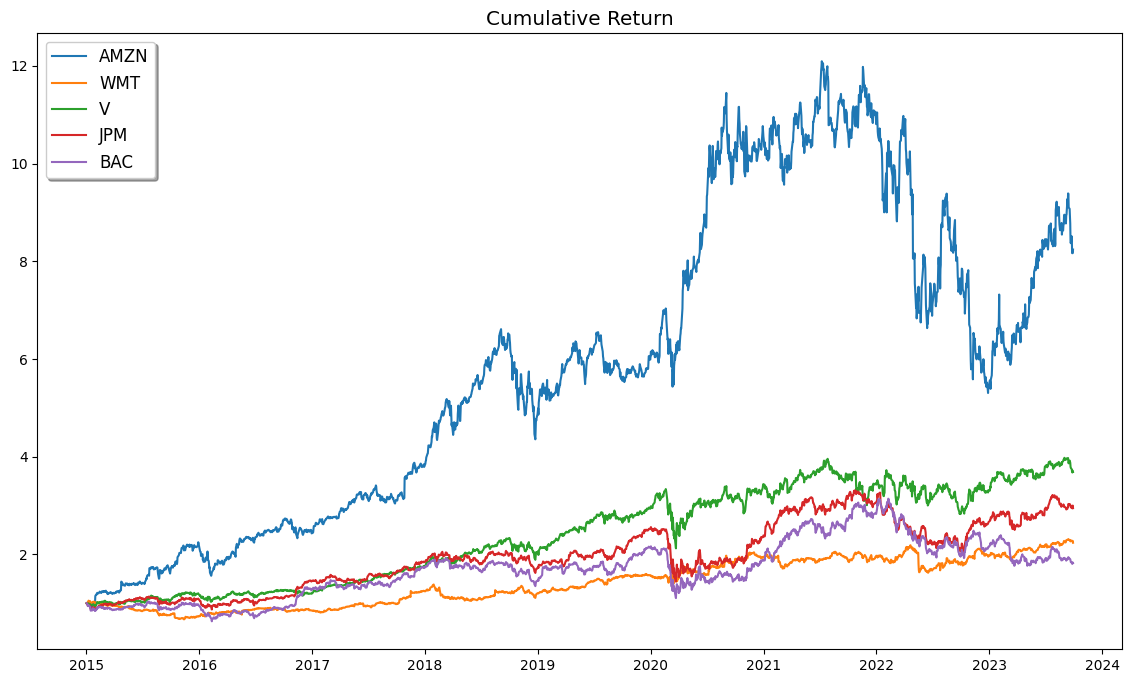

In [ ]:
df = pd.DataFrame()
df_ret = pd.DataFrame()
for tick in tickers:
  price = yf.download(tick, start = start_date, end = end_date)
  plt.plot(price['Adj Close']/price['Adj Close'][0], label = tick)
  price = price.rename(columns={'Adj Close': tick})
  price[tick+'ret'] = price[tick].pct_change()
  df = pd.concat([df, price[[tick]]],axis=1)
  df_ret = pd.concat([df, price[[tick+'ret']]], axis=1)

pdata = df.to_numpy()
pdata_dates = pd.to_datetime(price.index, format='%Y-%m-%d')
legend = plt.legend(loc='upper left', shadow = True, fontsize='large')
title = 'Cumulative Return'
plt.title(title, fontsize='x-large')
fig = plt.gcf()
fig.set_size_inches(14,8)
plt.show()

In [ ]:
df = pd.DataFrame()
for tick in tickers:
  ydata = yf.download(tick, start= start_date, end= end_date)
  df[tick]= ydata['Adj Close']
df.index = pd.to_datetime(ydata.index, format='%Y%m%d')

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [ ]:
df = df.pct_change(axis=0) # Daily Returns

In [ ]:
df.corr()

,AMZN,WMT,V,JPM,BAC
AMZN,1.000000,0.256922,0.477255,0.302320,0.316788
WMT,0.256922,1.000000,0.298181,0.268078,0.250991
V,0.477255,0.298181,1.000000,0.597359,0.578870
JPM,0.302320,0.268078,0.597359,1.000000,0.908346
BAC,0.316788,0.250991,0.578870,0.908346,1.000000


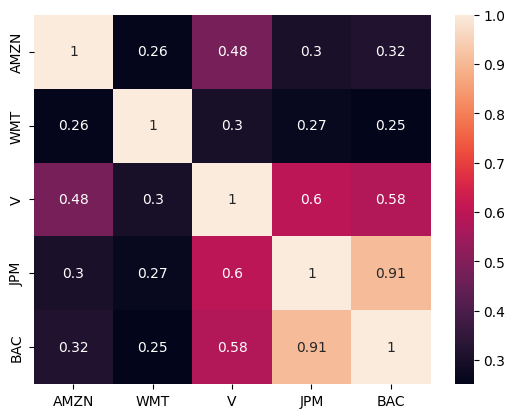

In [ ]:
sns.heatmap(df.corr(), annot=True);

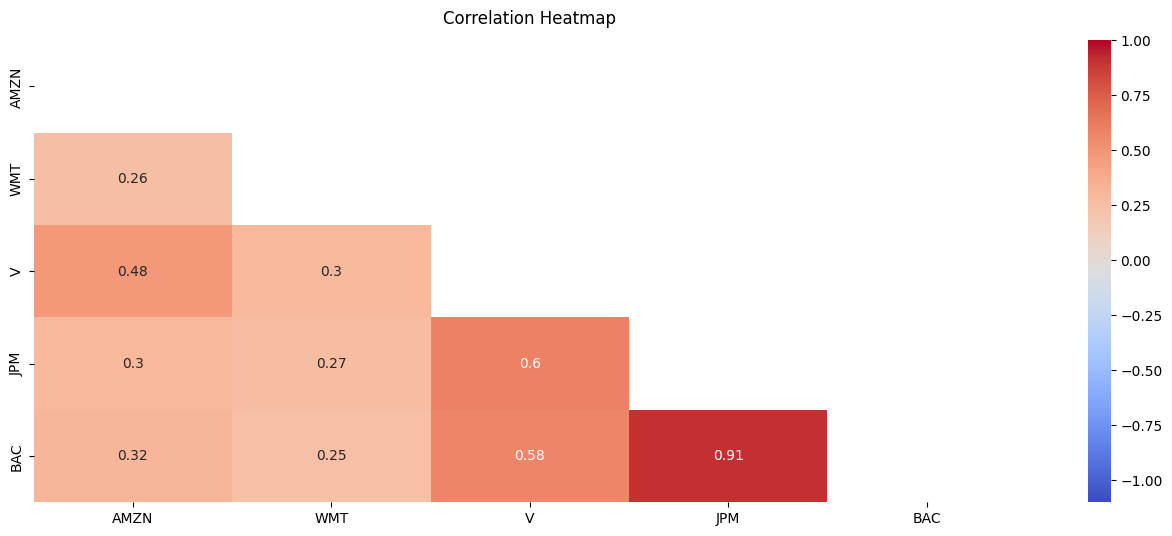

In [ ]:
plt.figure(figsize=(16,6))
mask = np.triu(np.ones_like(df.corr()))

heatmap = sns.heatmap(df.corr(), mask=mask, vmin=1, vmax=-1, cmap='coolwarm', annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

Cluster map will make hierarchical clustering according to pair wise correlation in stock returns

<Figure size 1600x600 with 0 Axes>

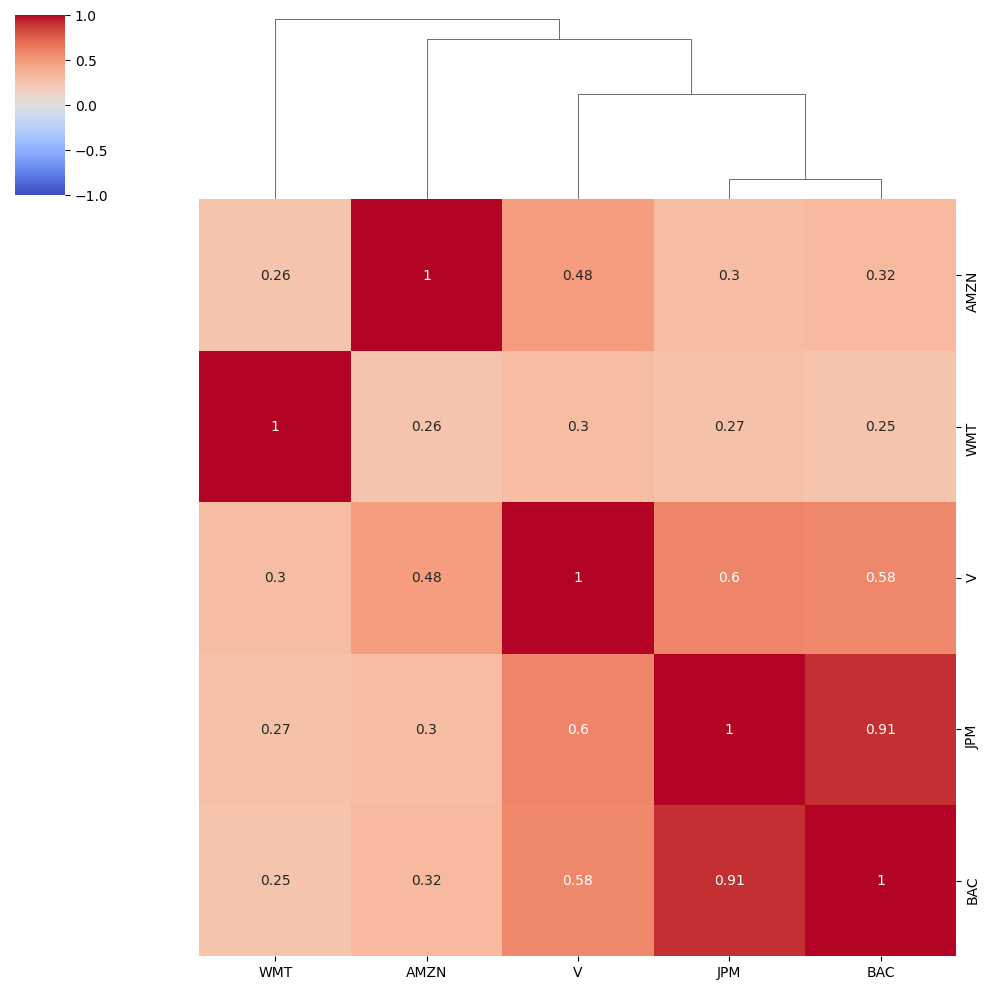

In [ ]:
plt.figure(figsize=(16,6))
mask = np.triu(np.ones_like(df.corr()))

heatmap = sns.clustermap(df.corr(), row_cluster=False, vmin=-1, vmax=1, cmap='coolwarm', annot=True);

Here three families are depicted:
1. JPM and BAC obviously they are banks so clustured as on group
2. V and banks are financial companies so there are more correlated
3. here depicted, AMZN is more related to financial companies than to the retail company like walmart

In [ ]:
def optimal_action(qvalue, eps):  # noQA E203
    """
    Determines what is the action to take given a measure of past
    expected rewards across actions. With probability eps the action
    is not the greedy one
    """
    nactions = qvalue.shape[0]
    action_hat = np.where(qvalue == np.max(qvalue))

    if rand() <= eps:
        randnum = rand()
        for aa in range(nactions):
            if randnum < (aa + 1) / nactions:  # noQA E203
                break
    elif action_hat[0].shape[0] > 1:  # noQA E203
        # Randomize action when ties
        randnum = rand()
        for aa in range(action_hat[0].shape[0]):  # noQA E203
            if randnum < (aa + 1) / action_hat[0].shape[0]:  # noQA E203
                break
        aa = action_hat[0][aa]
    else:
        aa = np.argmax(qvalue)

    return aa


def reward_update(action, reward, qvalue_old, alpha):  # noQA E203
    qvalue_new = qvalue_old.copy()

    qvalue_new[action] = qvalue_old[action] + alpha * (reward - qvalue_old[action])

    return qvalue_new

In [ ]:
# Bandit problem for stock selection

NK = pdata.shape[1]
EPSILON = 0.1
ALPHA = 0.85
NEPISODES = 1000
HOLD = 1 # holding period one day
TMAX = pdata.shape[0] - HOLD

# New Parameters
UCB_WEIGHT = 1.0

seed(1234)


reward_avg = np.zeros((TMAX))
optimal_avg = np.zeros((TMAX))

reward_queue = np.zeros((HOLD, 2))

for run in range(NEPISODES):
    # Initialize q function and actions record
    qvalue = np.zeros((NK))
    qvalue_up = np.zeros((NK))
    nactions = np.zeros((NK))
    for tt in range(TMAX):  # noQA E203
        aa_opt = optimal_action(qvalue_up, EPSILON)
        nactions[aa_opt] += 1
        # Compute reward as return over holding period
        reward_queue[HOLD - 1, 0] = (
            pdata[tt + HOLD, aa_opt] - pdata[tt, aa_opt]
        ) / pdata[tt, aa_opt]
        reward_queue[HOLD - 1, 1] = aa_opt
        # Update Q function using action chosen HOLD days before
        # For equally weighted
        # ALPHA = 1/nactions[aa_opt]
        qvalue = reward_update(
            int(reward_queue[0, 1]), reward_queue[0, 0], qvalue, ALPHA
        )
        # Upper-confidence adjustment
        qvalue_up = np.zeros((NK))
        for aa in range(NK):
            if nactions[aa] == 0:  # noQA E203
                qvalue_up[aa] = np.max(qvalue) + 1.0
            else:
                qvalue_up[aa] = qvalue[aa] + np.sqrt(np.log(tt + 1) / nactions[aa])
        reward_queue[0 : HOLD - 1, :] = reward_queue[1:HOLD, :]  # noQA E203
        reward_avg[tt] += reward_queue[HOLD - 1, 0] / NEPISODES
        optimal_avg[tt] += (
            aa_opt == np.argmax((pdata[tt + HOLD, :] - pdata[tt, :]) / pdata[tt, :])
        ) / NEPISODES  # noQA E203

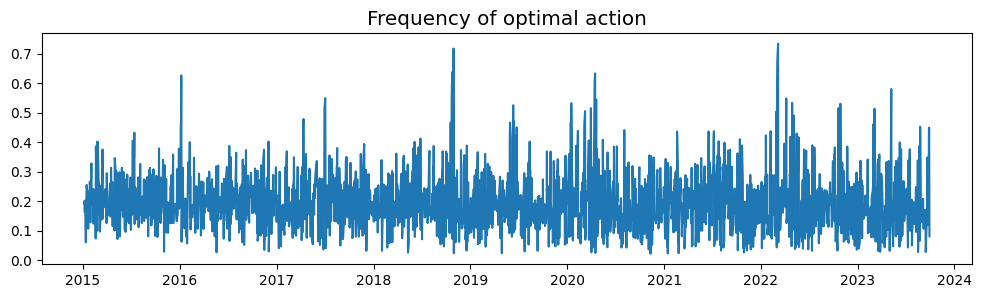

In [ ]:
plt.plot(pdata_dates[HOLD:pdata.shape[0]], optimal_avg)
plt.title("Frequency of optimal action", fontsize='x-large')
fig = plt.gcf()
fig.set_size_inches(12,3)
plt.show()

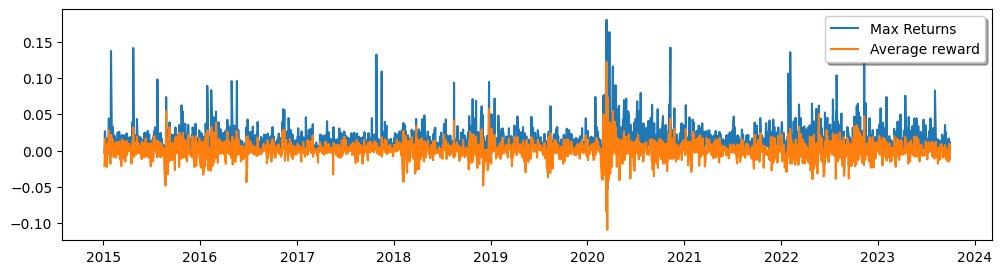

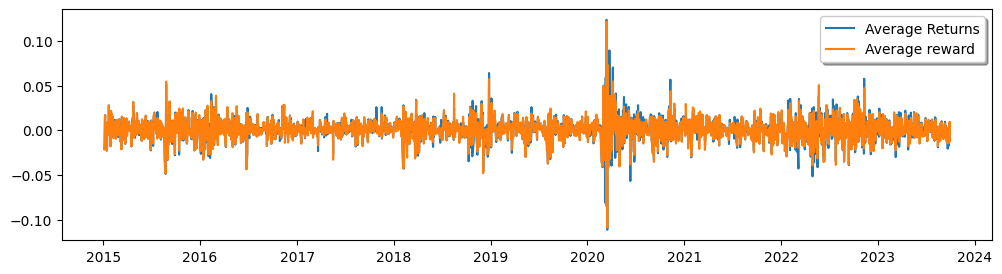

0.19612272727272742
0.1899957556055336 0.28273863591707177
0.1908351217231059 0.1952063292361375


In [ ]:
plt.plot(pdata_dates[HOLD:pdata.shape[0]], np.max((pdata[HOLD:pdata.shape[0],:]-pdata[0:TMAX,:])/pdata[0:TMAX,:], axis=1), label='Max Returns')
plt.plot(pdata_dates[HOLD:pdata.shape[0]], reward_avg, label='Average reward')
legend = plt.legend(loc='upper right', shadow=True)
fig = plt.gcf()
fig.set_size_inches(12,3)
plt.show()

plt.plot(pdata_dates[HOLD:pdata.shape[0]], np.mean((pdata[HOLD:pdata.shape[0],:]-pdata[0:TMAX,:])/pdata[0:TMAX,:], axis=1), label='Average Returns')
plt.plot(pdata_dates[HOLD:pdata.shape[0]], reward_avg, label='Average reward')
legend = plt.legend(loc='upper right', shadow=True)
fig = plt.gcf()
fig.set_size_inches(12,3)
plt.show()

# Average frequency of optimal action
print(np.mean(optimal_avg))

# Average annualizedreturn from holding the equally-weighted portfolio
print((1 + np.mean((pdata[HOLD:pdata.shape[0],:]-pdata[0:TMAX,:])/pdata[0:TMAX,:])) ** (250/HOLD) - 1, np.sqrt(250/HOLD) * np.std((pdata[HOLD:pdata.shape[0],:]-pdata[0:TMAX,:])/pdata[0:TMAX,:]))

# Average annualized return from holding the Bandit portfolio
print((1 + np.mean(reward_avg))** (250/HOLD) - 1, np.sqrt(250/HOLD) * np.std(reward_avg))

We see that agent, on average, not able to identify the best stock but with benchmark with equally weighted portfolio , there seems some period of time in which the agent is performing quite well. Its identifying which stock is performing better. Probably, it seems thtat there's some sort of momentum in daily returns so that the agent is able to identify the right stock or at least good stocks.

From the results, we performed worse than a pure random but slighly better than equally weighted portfolio and slightly less volatile. Though this difference is not statistically significant.

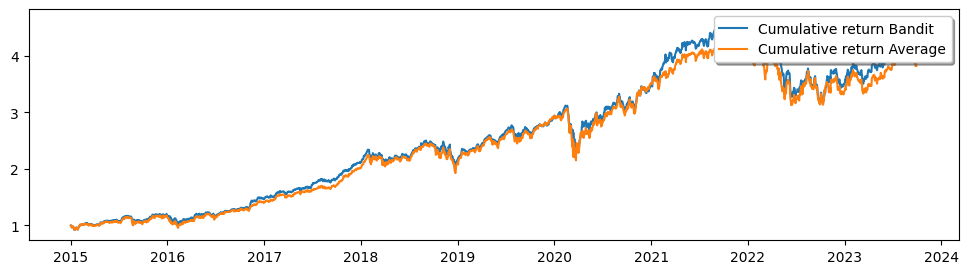

In [ ]:
return_cumulative = np.zeros((TMAX+1,2))
return_cumulative[0,0] = 1
return_cumulative[0,1] = 1

for tt in range(1, TMAX+1):
  return_cumulative[tt,0] = return_cumulative[tt-1, 0] * (1+reward_avg[tt-1] )
  rmean = np.mean((pdata[tt+HOLD-1,:]-pdata[tt-1,:])/pdata[tt-1,:])
  return_cumulative[tt,1] = return_cumulative[tt-1,1] * (1+ rmean)

plt.plot(pdata_dates[HOLD-1:pdata.shape[0]], return_cumulative[:,0], label='Cumulative return Bandit')
plt.plot(pdata_dates[HOLD-1:pdata.shape[0]], return_cumulative[:,1], label='Cumulative return Average')
legend = plt.legend(loc='upper right', shadow=True)

fig = plt.gcf()
fig.set_size_inches(12,3)
plt.show()

Agent seems to learn a strategy that is some what better than an equally weighted portfolio.

Multi-armed bandit algorithm applies well to those situations in which the agent takes action and doesn't have information about counterparts.

In the context of stock picking, it seems that the agent really observed to have the information about the returns of other stocks that have not een chosen by the agent. Although, there are situations in stock picking or portfolio selection problem where this randomness or lack of counter parts is still relevant.